In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [2]:
import geopy
import geopandas

In [3]:
arrests = pd.read_csv('Arrests.csv')

In [5]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17380 entries, 0 to 17379
Data columns (total 12 columns):
ArrestID              17380 non-null int64
ArrestDatetime        17380 non-null object
FirstName             17378 non-null object
HouseNumber           15450 non-null float64
LastName              17380 non-null object
MiddleName            16236 non-null object
NameSuffix            1610 non-null object
Statute               17362 non-null object
StatuteDescription    17362 non-null object
Street                16497 non-null object
Race                  17363 non-null object
Sex                   17372 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 1.6+ MB


In [4]:
arrests.head()

,ArrestID,ArrestDatetime,FirstName,HouseNumber,LastName,MiddleName,NameSuffix,Statute,StatuteDescription,Street,Race,Sex
0,1001,2019-06-13T07:19:00.000Z,CHRISTOPHER,1505.0,STANLEY,DEAN,NaN,18.2-415,Disturbing the peace,UNIVERSITY AVE,Black,Female
1,1002,2019-06-13T06:59:00.000Z,GABRIEL,109.0,SANTOS,J,NaN,18.2-388,PROFANE SWEARING OR INTOXICATION IN PUBLIC,CULBRETH RD,White,Male
2,1003,2019-06-13T04:00:00.000Z,CAROLYN,350.0,RICE,PAIGE,NaN,18.2-111,Embezzlement,PARK ST,White,Female
3,1004,2019-06-13T00:02:00.000Z,MICHAEL,7051.0,COOPER,JEROME,NaN,19.2-306,PROBATION VIOLATION - TYPE NOT CLEAR FROM RECORD,LOUISA RD,Black,Male
4,1005,2019-06-12T18:15:00.000Z,Roy,606.0,Correll,Chapman,NaN,18.2-137(B)(i),"MONUMENT: INTENTIONAL DAMAGE, VALUE <$1000",E MARKET ST,White,Male


To convert the date, we will split it into two columns. One will be a float64 in units of months (do we ignore the year?). The other will be a float64 in units of hours.

In [4]:
def null_values(df, return_table=True):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(4)
    print("There are", len(df.columns), "columns in total.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    if return_table:
        return mis_val_table_ren_columns

The only nonmissing features are the ID, the date and time, and the last name.

In [5]:
miss_values = null_values(arrests)
pd.set_option('display.max_rows', None)
miss_values

There are 12 columns in total.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
NameSuffix,15770,90.7365
HouseNumber,1930,11.1047
MiddleName,1144,6.5823
Street,883,5.0806
Statute,18,0.1036
StatuteDescription,18,0.1036
Race,17,0.0978
Sex,8,0.0460
FirstName,2,0.0115


To impute missing data in 'Sex', all nan values should be replaced with 'Unknown'.

In [7]:
arrests['Sex'].unique()

array(['Female', 'Male', nan, 'Unknown'], dtype=object)

The two rows without first names are interesting. In the row with ID 2262, the last name is a placeholder 'JOHN DOE'.

In [23]:
arrests.loc[arrests['FirstName'] != arrests['FirstName']]

,ArrestID,ArrestDatetime,FirstName,HouseNumber,LastName,MiddleName,NameSuffix,Statute,StatuteDescription,Street,Race,Sex
696,1697,2019-03-15T00:38:00.000Z,NaN,NaN,PURPLERAIN,NaN,NaN,905,DRUNKENESS,BROWN ST,Black,Female
5261,2262,2018-12-24T13:06:00.000Z,NaN,1131.0,JOHN DOE,NaN,NaN,18.2-388,PROFANE SWEARING OR INTOXICATION IN PUBLIC,5TH ST SW,White,Male


What are 'nwt', 'doc', and 'jpg' doing in the 'Race' feature?

In [ ]:
arrests.loc[arrests['Race'] == 'nwt']

In [ ]:
arrests.loc[arrests['Race'] == 'doc']

We see that there are multiple descriptions that correspond to the same statute. Therefore, we drop the StatuteDescription feature because it does not add anything to the data.

If we keep the names, it is reasonable to perform feature engineering that assigns a unique number to a full name, including the suffix if applicable, since we see that one person can and often commits more than one offense. We will have to convert every name to uppercase, since the capitalization is inconsistent.

There are 472 unique statutes. A OneHotEncoder will result in the number of features increasing to about 480.

In [24]:
arrests['NameSuffix'].unique()

array([nan, 'Jr', 'II', 'III', 'Sr', 'IV'], dtype=object)

In [ ]:
arrests['StatuteDescription'].value_counts()

In [ ]:
arrests['Statute'].value_counts()

In [19]:
arrests['Statute'].nunique()

472

## Data cleaning

We drop the ArrestID and StatuteDescription because the former is useless and the latter is redundant with Statute. In fact, there are many descriptions that can potentially refer to the same statute. We also drop the names since there are too many unique names for an analysis to be useful with them kept.

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
arrests = pd.read_csv('Arrests.csv')

In [6]:
useless_and_redundant = ['ArrestID', 'StatuteDescription']
names = ['FirstName', 'LastName', 'MiddleName', 'NameSuffix']
arrests.drop(useless_and_redundant, axis=1, inplace=True)
arrests.drop(names, axis=1, inplace=True)

In [7]:
arrests['Year'] = pd.to_datetime(arrests['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%Y')) if x == x else np.nan)
arrests['Month'] = pd.to_datetime(arrests['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%m')) if x == x else np.nan) 
arrests['Day'] = pd.to_datetime(arrests['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%d')) if x == x else np.nan) 
arrests['Time'] = pd.to_datetime(arrests['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%H')) + 1/60 * float(x.strftime('%M')) + 1/3600 * float(x.strftime('%S'))
    if x == x else np.nan)

In [8]:
def convert_housenumber(x):
    if x == x:
        return str(int(x))
    else:
        return ''

arrests['HouseNumber'] = arrests['HouseNumber'].apply(convert_housenumber)
arrests['Address'] = arrests['HouseNumber'] + ' ' + arrests['Street'] + ', CHARLOTTESVILLE, VA'
arrests.drop(['ArrestDatetime', 'HouseNumber', 'Street'], axis=1, inplace=True)

We will use OneHotEncoding for race and sex.

In [9]:
onehot = OneHotEncoder()

def convert_races(x):
    if x == 'Unknown' or x == 'nwt' or x == 'doc' or x == 'jpg' or x != x:
        return 'Unknown Race'
    else:
        return x

def convert_sex(x):
    if x == 'Unknown' or x != x:
        return 'Unknown Sex'
    else:
        return x
    
arrests['Race'] = arrests['Race'].apply(convert_races)    
arrests['Sex'] = arrests['Sex'].apply(convert_sex)

cat_onehot = arrests[['Race', 'Sex']]
mtx_onehot = onehot.fit_transform(cat_onehot).toarray()
df_onehot = pd.DataFrame(mtx_onehot, columns=np.concatenate(onehot.categories_))
arrests.drop(['Race', 'Sex'], axis=1, inplace=True)
arrests = pd.concat([arrests, df_onehot], axis=1)

In [10]:
arrests.head()

,Statute,Year,Month,Day,Time,Address,American Indian/Alaskan Native,Asian or Pacific Islander,Black,Unknown Race,White,Female,Male,Unknown Sex
0,18.2-415,2019.0,6.0,13.0,7.316667,1505 UNIVERSITY AVE,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,18.2-388,2019.0,6.0,13.0,6.983333,109 CULBRETH RD,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,18.2-111,2019.0,6.0,13.0,4.000000,350 PARK ST,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,19.2-306,2019.0,6.0,13.0,0.033333,7051 LOUISA RD,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,18.2-137(B)(i),2019.0,6.0,12.0,18.250000,606 E MARKET ST,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [243]:
miss_values = null_values(arrests)
pd.set_option('display.max_rows', None)
miss_values

There are 14 columns in total.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Address,883,5.0806
Statute,18,0.1036


We shall remove those entries with missing addresses and statutes.

In [10]:
arrests.dropna(subset=['Address', 'Statute'], how='any', inplace=True)

In [11]:
miss_values = null_values(arrests)
pd.set_option('display.max_rows', None)
miss_values

There are 14 columns in total.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [246]:
arrests.head(25)

,Statute,Year,Month,Day,Time,Address,American Indian/Alaskan Native,Asian or Pacific Islander,Black,Unknown Race,White,Female,Male,Unknown Sex
0,18.2-415,2019.0,6.0,13.0,7.316667,"1505 UNIVERSITY AVE, CHARLOTTESVILLE, VA",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,18.2-388,2019.0,6.0,13.0,6.983333,"109 CULBRETH RD, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,18.2-111,2019.0,6.0,13.0,4.000000,"350 PARK ST, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,19.2-306,2019.0,6.0,13.0,0.033333,"7051 LOUISA RD, CHARLOTTESVILLE, VA",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,18.2-137(B)(i),2019.0,6.0,12.0,18.250000,"606 E MARKET ST, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,18.2-137(B)(i),2019.0,6.0,12.0,13.933333,"606 E MARKET ST, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,18.2-181,2019.0,6.0,12.0,1.266667,"3904 VILLAGE TOWNES WALK, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7,18.2-181,2019.0,6.0,12.0,1.266667,"3904 VILLAGE TOWNES WALK, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8,18.2-250(A)(a),2019.0,6.0,12.0,0.433333,"EMARKET ST, CHARLOTTESVILLE, VA",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,19.2-128(B),2019.0,6.0,12.0,0.433333,"EMARKET ST, CHARLOTTESVILLE, VA",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [12]:
from geopy.extra.rate_limiter import RateLimiter

locator = geopy.Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=2)

Let us deal with the first 100 entries of the dataset. The geocoding will take a while.

In [13]:
df = arrests.head(100)
# location = locator.geocode("Jefferson Park Ave, Charlottesville, VA")

In [14]:
df['Location'] = df['Address'].apply(geocode)
df['Point'] = df['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df['Point'].tolist(), index=df.index)


RateLimiter caught an error, retrying (0/2 tries). Called with (*('1435 COURTHOUSE RD, CHARLOTTESVILLE, VA',), **{}).
Traceback (most recent call last):
  File "/usr/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/usr/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/usr/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/usr/lib/python3.6/http/client.py", line 936, in connect


In [18]:
df.dropna(how='any', axis=0, inplace=True)
df.drop(['Address', 'Location', 'Point', 'Altitude'], axis=1, inplace=True)

/home/ajiao/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ajiao/.local/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


From the first 100 entries, 65 are valid addresses and are in the city of Charlottesville. Others are in the suburbs or are further out. We shall only consider those incidents in Charlottesville.

In [20]:
len(df)

65

In [22]:
df.head()

,Statute,Year,Month,Day,Time,Address,American Indian/Alaskan Native,Asian or Pacific Islander,Black,Unknown Race,White,Female,Male,Unknown Sex,Latitude,Longitude
0,18.2-415,2019.0,6.0,13.0,7.316667,"1505 UNIVERSITY AVE, CHARLOTTESVILLE, VA",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,38.034727,-78.500341
1,18.2-388,2019.0,6.0,13.0,6.983333,"109 CULBRETH RD, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,38.039730,-78.503874
2,18.2-111,2019.0,6.0,13.0,4.000000,"350 PARK ST, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.031651,-78.476557
4,18.2-137(B)(i),2019.0,6.0,12.0,18.250000,"606 E MARKET ST, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,38.031753,-78.481942
5,18.2-137(B)(i),2019.0,6.0,12.0,13.933333,"606 E MARKET ST, CHARLOTTESVILLE, VA",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,38.031753,-78.481942


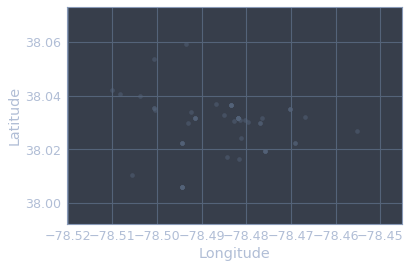

In [25]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5)

In [ ]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
    s=housing["population"]/100, figsize=(10, 7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)